# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:07<00:00, 7.68KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

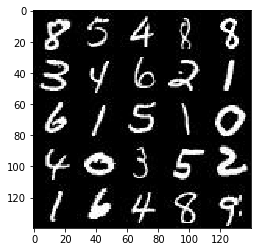

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

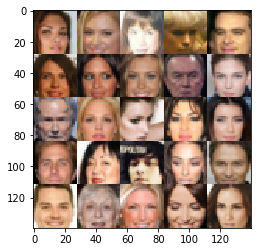

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0


/home/aleph/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [54]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name="input_real")
    input_z = tf.placeholder(tf.float32, shape=(None,z_dim), name="input_z")
    learning_rate = tf.placeholder(tf.float32, None, name="learning_rate")

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [55]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    kernel_init = tf.random_normal_initializer(stddev=0.02)
    keep_probability = 0.7
    with tf.variable_scope("discriminator", reuse=reuse):
        #input is 28x28x3 for celebA
        x = tf.layers.conv2d(images, 64, 5, strides=2, kernel_initializer=kernel_init, padding="same")
        x = tf.nn.dropout(x, keep_probability)
        x = tf.maximum(x*alpha, x)
        #print("discriminator 1, ", x.shape)
        #14x14x64
        
        x = tf.layers.conv2d(x, 128, 5, strides=2, kernel_initializer=kernel_init, padding="same")
        x = tf.nn.dropout(x, keep_probability)
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(x*alpha, x)
        #print("discriminator 2, ", x.shape)
        #7x7x128
        
        x = tf.layers.conv2d(x, 256, 5, strides=2, kernel_initializer=kernel_init, padding="same")
        x = tf.nn.dropout(x, keep_probability)
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(x*alpha, x)
        #print("discriminator 3, ", x.shape)
        #4x4x256
        
        flat = tf.reshape(x, (-1,4*4*256))
        logits = tf.layers.dense(flat, 1, kernel_initializer=kernel_init)
        logits = tf.nn.dropout(logits, keep_probability)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [56]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    kernel_init=tf.random_normal_initializer(stddev=0.02)
    with tf.variable_scope("generator", reuse = not is_train):
        #Fist fully connected layer
        x = tf.layers.dense(z,7*7*256)
        #reshape it to start the convolutional stack
        x = tf.reshape(x, (-1,7,7,256))
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(x*alpha, x)
        #7x7x256 now
        
        x = tf.layers.conv2d_transpose(x, 128, 5, strides=2, kernel_initializer=kernel_init, padding="same")
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(x*alpha,x)
        #14x14x128 now
        
        x = tf.layers.conv2d_transpose(x, 64, 5, strides=2, kernel_initializer=kernel_init, padding="same")
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(x*alpha,x)
        #28x28x64 now
        
        logits = tf.layers.conv2d_transpose(x, out_channel_dim, 3, strides=1, kernel_initializer=kernel_init, 
                                            padding="same")
        #28x28xout_channel_dim now
    
        out = tf.tanh(logits) 
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [62]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
        
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                                         labels=tf.ones_like(d_model_real)*(1-0.1)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                         labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                   labels=tf.ones_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [58]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    #Get weights an bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith("discriminator")]
    g_vars = [var for var in t_vars if var.name.startswith("generator")]
    
    #Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [63]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [71]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    print_every=10
    show_every=100
    samples, losses = [], []
    steps = 0
    
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
        
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2.0
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images,
                                               input_z: batch_z,
                                               lr:learning_rate})

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.4341... Generator Loss: 0.5470
Epoch 1/2... Discriminator Loss: 1.9643... Generator Loss: 0.3561
Epoch 1/2... Discriminator Loss: 1.8341... Generator Loss: 0.4482
Epoch 1/2... Discriminator Loss: 2.4904... Generator Loss: 0.3811
Epoch 1/2... Discriminator Loss: 1.6830... Generator Loss: 0.5100
Epoch 1/2... Discriminator Loss: 1.6486... Generator Loss: 0.4801
Epoch 1/2... Discriminator Loss: 1.6118... Generator Loss: 0.8106
Epoch 1/2... Discriminator Loss: 1.7557... Generator Loss: 0.3836
Epoch 1/2... Discriminator Loss: 1.9525... Generator Loss: 0.4340
Epoch 1/2... Discriminator Loss: 1.5691... Generator Loss: 1.1876


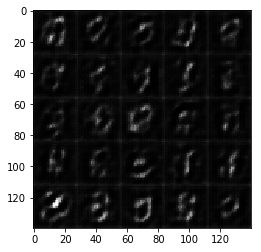

Epoch 1/2... Discriminator Loss: 1.5462... Generator Loss: 1.2143
Epoch 1/2... Discriminator Loss: 1.3930... Generator Loss: 0.7240
Epoch 1/2... Discriminator Loss: 1.6174... Generator Loss: 0.5474
Epoch 1/2... Discriminator Loss: 1.6891... Generator Loss: 0.4259
Epoch 1/2... Discriminator Loss: 1.8190... Generator Loss: 0.3450
Epoch 1/2... Discriminator Loss: 1.4763... Generator Loss: 0.8106
Epoch 1/2... Discriminator Loss: 1.3532... Generator Loss: 0.8600
Epoch 1/2... Discriminator Loss: 1.4100... Generator Loss: 0.6656
Epoch 1/2... Discriminator Loss: 1.6258... Generator Loss: 1.0417
Epoch 1/2... Discriminator Loss: 1.5066... Generator Loss: 0.8080


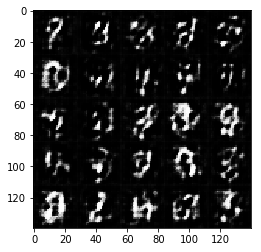

Epoch 1/2... Discriminator Loss: 1.4676... Generator Loss: 0.7302
Epoch 1/2... Discriminator Loss: 1.3817... Generator Loss: 0.7181
Epoch 1/2... Discriminator Loss: 1.6828... Generator Loss: 0.6363
Epoch 1/2... Discriminator Loss: 1.4449... Generator Loss: 0.5615
Epoch 1/2... Discriminator Loss: 1.6796... Generator Loss: 1.5621
Epoch 1/2... Discriminator Loss: 1.4935... Generator Loss: 0.6382
Epoch 1/2... Discriminator Loss: 1.4250... Generator Loss: 0.7193
Epoch 1/2... Discriminator Loss: 1.3718... Generator Loss: 0.7802
Epoch 1/2... Discriminator Loss: 1.4680... Generator Loss: 0.5631
Epoch 1/2... Discriminator Loss: 1.5976... Generator Loss: 0.4859


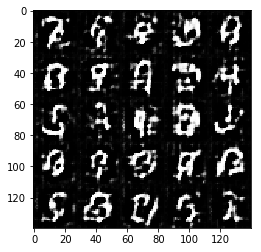

Epoch 1/2... Discriminator Loss: 1.4140... Generator Loss: 0.7372
Epoch 1/2... Discriminator Loss: 1.4363... Generator Loss: 0.6396
Epoch 1/2... Discriminator Loss: 1.4109... Generator Loss: 0.7751
Epoch 1/2... Discriminator Loss: 1.4218... Generator Loss: 1.0579
Epoch 1/2... Discriminator Loss: 1.4132... Generator Loss: 0.6333
Epoch 1/2... Discriminator Loss: 1.3378... Generator Loss: 0.8334
Epoch 1/2... Discriminator Loss: 1.4586... Generator Loss: 1.0844
Epoch 1/2... Discriminator Loss: 1.4656... Generator Loss: 0.9312
Epoch 1/2... Discriminator Loss: 1.4151... Generator Loss: 0.8939
Epoch 1/2... Discriminator Loss: 1.7019... Generator Loss: 1.2964


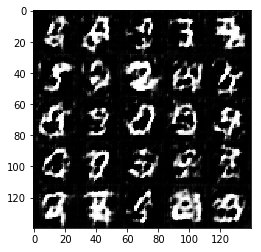

Epoch 1/2... Discriminator Loss: 1.4512... Generator Loss: 0.6733
Epoch 1/2... Discriminator Loss: 1.4169... Generator Loss: 0.6915
Epoch 1/2... Discriminator Loss: 1.5319... Generator Loss: 1.2443
Epoch 1/2... Discriminator Loss: 1.4309... Generator Loss: 0.5574
Epoch 1/2... Discriminator Loss: 1.3992... Generator Loss: 0.8325
Epoch 1/2... Discriminator Loss: 1.4996... Generator Loss: 0.8868
Epoch 1/2... Discriminator Loss: 1.4048... Generator Loss: 0.5834
Epoch 1/2... Discriminator Loss: 1.3673... Generator Loss: 0.7944
Epoch 1/2... Discriminator Loss: 1.4058... Generator Loss: 0.8020
Epoch 1/2... Discriminator Loss: 1.5919... Generator Loss: 1.0943


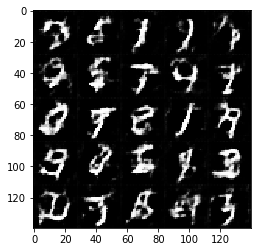

Epoch 1/2... Discriminator Loss: 1.3717... Generator Loss: 0.9129
Epoch 1/2... Discriminator Loss: 1.5912... Generator Loss: 1.2976
Epoch 1/2... Discriminator Loss: 1.4212... Generator Loss: 0.7600
Epoch 1/2... Discriminator Loss: 1.4141... Generator Loss: 0.9386
Epoch 1/2... Discriminator Loss: 1.4388... Generator Loss: 0.5762
Epoch 1/2... Discriminator Loss: 1.5775... Generator Loss: 0.5295
Epoch 1/2... Discriminator Loss: 1.5348... Generator Loss: 0.5672
Epoch 1/2... Discriminator Loss: 1.4675... Generator Loss: 0.7573
Epoch 1/2... Discriminator Loss: 1.3452... Generator Loss: 0.8964
Epoch 1/2... Discriminator Loss: 1.4553... Generator Loss: 0.8257


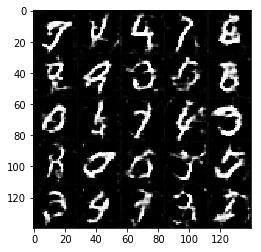

Epoch 1/2... Discriminator Loss: 1.6598... Generator Loss: 0.5180
Epoch 1/2... Discriminator Loss: 1.4142... Generator Loss: 0.8873
Epoch 1/2... Discriminator Loss: 1.5254... Generator Loss: 0.6381
Epoch 1/2... Discriminator Loss: 1.3638... Generator Loss: 0.8750
Epoch 1/2... Discriminator Loss: 1.4731... Generator Loss: 0.7447
Epoch 1/2... Discriminator Loss: 1.4332... Generator Loss: 0.8639
Epoch 1/2... Discriminator Loss: 1.3653... Generator Loss: 0.8639
Epoch 1/2... Discriminator Loss: 1.3464... Generator Loss: 0.7569
Epoch 1/2... Discriminator Loss: 1.3726... Generator Loss: 0.7861
Epoch 1/2... Discriminator Loss: 1.3654... Generator Loss: 1.0747


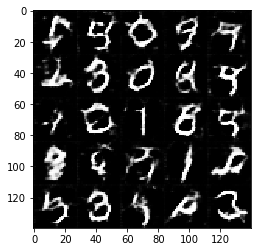

Epoch 1/2... Discriminator Loss: 1.4238... Generator Loss: 0.7880
Epoch 1/2... Discriminator Loss: 1.4192... Generator Loss: 1.0257
Epoch 1/2... Discriminator Loss: 1.5384... Generator Loss: 0.7080
Epoch 1/2... Discriminator Loss: 1.3816... Generator Loss: 0.8925
Epoch 1/2... Discriminator Loss: 1.3939... Generator Loss: 0.6172
Epoch 1/2... Discriminator Loss: 1.3228... Generator Loss: 1.1364
Epoch 1/2... Discriminator Loss: 1.3868... Generator Loss: 0.7544
Epoch 1/2... Discriminator Loss: 1.4530... Generator Loss: 0.6161
Epoch 1/2... Discriminator Loss: 1.3124... Generator Loss: 0.8029
Epoch 1/2... Discriminator Loss: 1.3911... Generator Loss: 0.7038


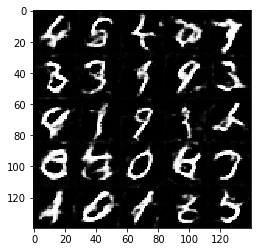

Epoch 1/2... Discriminator Loss: 1.3796... Generator Loss: 0.7676
Epoch 1/2... Discriminator Loss: 1.3302... Generator Loss: 1.0796
Epoch 1/2... Discriminator Loss: 1.5127... Generator Loss: 0.4999
Epoch 1/2... Discriminator Loss: 1.4605... Generator Loss: 1.0189
Epoch 1/2... Discriminator Loss: 1.4045... Generator Loss: 0.7114
Epoch 1/2... Discriminator Loss: 1.3932... Generator Loss: 0.7466
Epoch 1/2... Discriminator Loss: 1.3268... Generator Loss: 1.0401
Epoch 1/2... Discriminator Loss: 1.3260... Generator Loss: 0.8129
Epoch 1/2... Discriminator Loss: 1.4179... Generator Loss: 0.7386
Epoch 1/2... Discriminator Loss: 1.3253... Generator Loss: 0.8781


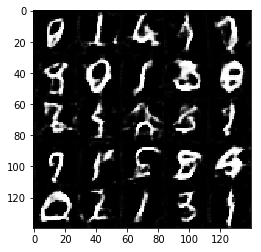

Epoch 1/2... Discriminator Loss: 1.5165... Generator Loss: 0.6039
Epoch 1/2... Discriminator Loss: 1.4905... Generator Loss: 0.6490
Epoch 1/2... Discriminator Loss: 1.3414... Generator Loss: 0.7603
Epoch 2/2... Discriminator Loss: 1.3654... Generator Loss: 0.8282
Epoch 2/2... Discriminator Loss: 1.4343... Generator Loss: 0.5742
Epoch 2/2... Discriminator Loss: 1.4035... Generator Loss: 0.7748
Epoch 2/2... Discriminator Loss: 1.4924... Generator Loss: 0.5286
Epoch 2/2... Discriminator Loss: 1.3363... Generator Loss: 0.7687
Epoch 2/2... Discriminator Loss: 1.4832... Generator Loss: 0.6459
Epoch 2/2... Discriminator Loss: 1.4018... Generator Loss: 0.9300


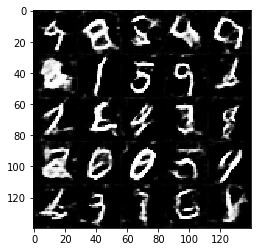

Epoch 2/2... Discriminator Loss: 1.3774... Generator Loss: 0.9228
Epoch 2/2... Discriminator Loss: 1.5253... Generator Loss: 0.5488
Epoch 2/2... Discriminator Loss: 1.3918... Generator Loss: 0.9344
Epoch 2/2... Discriminator Loss: 1.5812... Generator Loss: 0.6196
Epoch 2/2... Discriminator Loss: 1.3684... Generator Loss: 0.6698
Epoch 2/2... Discriminator Loss: 1.4294... Generator Loss: 1.0105
Epoch 2/2... Discriminator Loss: 1.3861... Generator Loss: 0.6507
Epoch 2/2... Discriminator Loss: 1.3767... Generator Loss: 0.8971
Epoch 2/2... Discriminator Loss: 1.4482... Generator Loss: 0.5751
Epoch 2/2... Discriminator Loss: 1.3689... Generator Loss: 0.6925


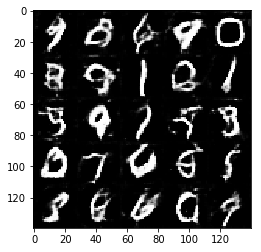

Epoch 2/2... Discriminator Loss: 1.3410... Generator Loss: 0.8888
Epoch 2/2... Discriminator Loss: 1.3625... Generator Loss: 0.7772
Epoch 2/2... Discriminator Loss: 1.4922... Generator Loss: 0.7004
Epoch 2/2... Discriminator Loss: 1.3487... Generator Loss: 0.7645
Epoch 2/2... Discriminator Loss: 1.3405... Generator Loss: 0.7545
Epoch 2/2... Discriminator Loss: 1.4248... Generator Loss: 0.7058
Epoch 2/2... Discriminator Loss: 1.3897... Generator Loss: 0.9972
Epoch 2/2... Discriminator Loss: 1.3715... Generator Loss: 0.8474
Epoch 2/2... Discriminator Loss: 1.3815... Generator Loss: 0.6665
Epoch 2/2... Discriminator Loss: 1.3555... Generator Loss: 0.9224


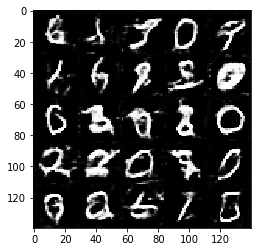

Epoch 2/2... Discriminator Loss: 1.4369... Generator Loss: 0.7492
Epoch 2/2... Discriminator Loss: 1.4335... Generator Loss: 0.7708
Epoch 2/2... Discriminator Loss: 1.3205... Generator Loss: 0.8059
Epoch 2/2... Discriminator Loss: 1.3279... Generator Loss: 0.8607
Epoch 2/2... Discriminator Loss: 1.3323... Generator Loss: 1.0455
Epoch 2/2... Discriminator Loss: 1.3153... Generator Loss: 0.7197
Epoch 2/2... Discriminator Loss: 1.3247... Generator Loss: 0.8652
Epoch 2/2... Discriminator Loss: 1.3004... Generator Loss: 0.8328
Epoch 2/2... Discriminator Loss: 1.4213... Generator Loss: 0.6593
Epoch 2/2... Discriminator Loss: 1.4255... Generator Loss: 0.7168


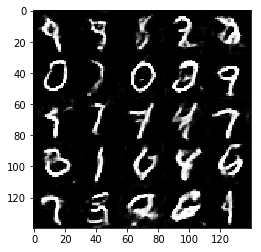

Epoch 2/2... Discriminator Loss: 1.3455... Generator Loss: 0.6899
Epoch 2/2... Discriminator Loss: 1.3819... Generator Loss: 0.6289
Epoch 2/2... Discriminator Loss: 1.3741... Generator Loss: 0.6241
Epoch 2/2... Discriminator Loss: 1.3311... Generator Loss: 0.8747
Epoch 2/2... Discriminator Loss: 1.4423... Generator Loss: 0.6748
Epoch 2/2... Discriminator Loss: 1.4237... Generator Loss: 0.6905
Epoch 2/2... Discriminator Loss: 1.3892... Generator Loss: 0.8270
Epoch 2/2... Discriminator Loss: 1.3539... Generator Loss: 0.8146
Epoch 2/2... Discriminator Loss: 1.3580... Generator Loss: 0.7705
Epoch 2/2... Discriminator Loss: 1.3092... Generator Loss: 0.7722


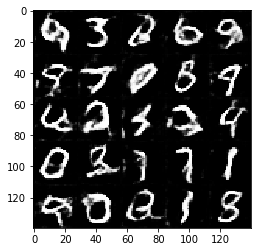

Epoch 2/2... Discriminator Loss: 1.3378... Generator Loss: 0.7910
Epoch 2/2... Discriminator Loss: 1.3138... Generator Loss: 0.9273
Epoch 2/2... Discriminator Loss: 1.3575... Generator Loss: 0.6396
Epoch 2/2... Discriminator Loss: 1.3033... Generator Loss: 0.7464
Epoch 2/2... Discriminator Loss: 1.3643... Generator Loss: 1.0705
Epoch 2/2... Discriminator Loss: 1.4037... Generator Loss: 0.6838
Epoch 2/2... Discriminator Loss: 1.3906... Generator Loss: 0.8051
Epoch 2/2... Discriminator Loss: 1.3766... Generator Loss: 0.9061
Epoch 2/2... Discriminator Loss: 1.4148... Generator Loss: 0.5615
Epoch 2/2... Discriminator Loss: 1.3098... Generator Loss: 0.7886


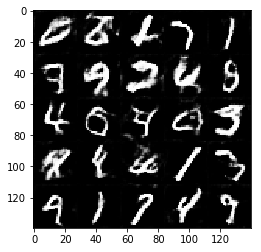

Epoch 2/2... Discriminator Loss: 1.2895... Generator Loss: 0.9333
Epoch 2/2... Discriminator Loss: 1.3235... Generator Loss: 0.8880
Epoch 2/2... Discriminator Loss: 1.3619... Generator Loss: 1.2008
Epoch 2/2... Discriminator Loss: 1.5867... Generator Loss: 0.5277
Epoch 2/2... Discriminator Loss: 1.3605... Generator Loss: 0.7389
Epoch 2/2... Discriminator Loss: 1.2144... Generator Loss: 0.7514
Epoch 2/2... Discriminator Loss: 1.3439... Generator Loss: 0.8124
Epoch 2/2... Discriminator Loss: 1.3566... Generator Loss: 0.7003
Epoch 2/2... Discriminator Loss: 1.3948... Generator Loss: 1.0170
Epoch 2/2... Discriminator Loss: 1.4137... Generator Loss: 0.9345


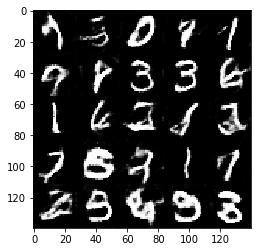

Epoch 2/2... Discriminator Loss: 1.5544... Generator Loss: 0.5611
Epoch 2/2... Discriminator Loss: 1.3702... Generator Loss: 1.0504
Epoch 2/2... Discriminator Loss: 1.3176... Generator Loss: 0.9396
Epoch 2/2... Discriminator Loss: 1.4705... Generator Loss: 0.5203
Epoch 2/2... Discriminator Loss: 1.3420... Generator Loss: 0.8063
Epoch 2/2... Discriminator Loss: 1.3256... Generator Loss: 1.2071
Epoch 2/2... Discriminator Loss: 1.3515... Generator Loss: 0.8870
Epoch 2/2... Discriminator Loss: 1.5969... Generator Loss: 1.1040
Epoch 2/2... Discriminator Loss: 1.4167... Generator Loss: 0.8441
Epoch 2/2... Discriminator Loss: 1.3082... Generator Loss: 0.7777


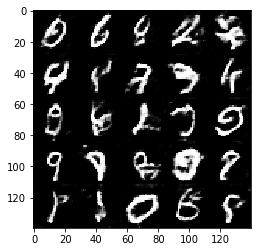

Epoch 2/2... Discriminator Loss: 1.3523... Generator Loss: 0.8555
Epoch 2/2... Discriminator Loss: 1.7036... Generator Loss: 0.4908
Epoch 2/2... Discriminator Loss: 1.3812... Generator Loss: 0.8217
Epoch 2/2... Discriminator Loss: 1.3421... Generator Loss: 0.9581
Epoch 2/2... Discriminator Loss: 1.3572... Generator Loss: 0.7091
Epoch 2/2... Discriminator Loss: 1.3183... Generator Loss: 0.8857
Epoch 2/2... Discriminator Loss: 1.3666... Generator Loss: 0.9753
Epoch 2/2... Discriminator Loss: 1.4145... Generator Loss: 0.6590
Epoch 2/2... Discriminator Loss: 1.4552... Generator Loss: 0.5853
Epoch 2/2... Discriminator Loss: 1.2597... Generator Loss: 0.9825


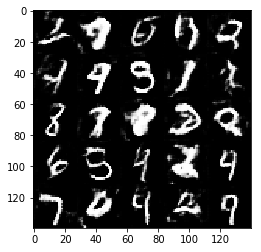

Epoch 2/2... Discriminator Loss: 1.4026... Generator Loss: 1.2100
Epoch 2/2... Discriminator Loss: 1.4215... Generator Loss: 0.8482
Epoch 2/2... Discriminator Loss: 1.3818... Generator Loss: 0.6021
Epoch 2/2... Discriminator Loss: 1.2919... Generator Loss: 0.7437
Epoch 2/2... Discriminator Loss: 1.3536... Generator Loss: 0.8240
Epoch 2/2... Discriminator Loss: 1.4346... Generator Loss: 0.5603
Epoch 2/2... Discriminator Loss: 1.3166... Generator Loss: 0.9235


In [72]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.2403... Generator Loss: 1.9475
Epoch 1/1... Discriminator Loss: 1.2146... Generator Loss: 1.7309
Epoch 1/1... Discriminator Loss: 1.2128... Generator Loss: 2.4568
Epoch 1/1... Discriminator Loss: 1.5164... Generator Loss: 0.5344
Epoch 1/1... Discriminator Loss: 1.4049... Generator Loss: 0.6741
Epoch 1/1... Discriminator Loss: 1.4329... Generator Loss: 0.6855
Epoch 1/1... Discriminator Loss: 1.4767... Generator Loss: 0.7898
Epoch 1/1... Discriminator Loss: 1.3551... Generator Loss: 0.9845
Epoch 1/1... Discriminator Loss: 1.2874... Generator Loss: 0.9451
Epoch 1/1... Discriminator Loss: 1.7439... Generator Loss: 0.5629


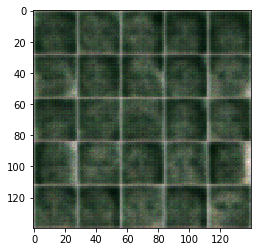

Epoch 1/1... Discriminator Loss: 1.4778... Generator Loss: 0.7055
Epoch 1/1... Discriminator Loss: 1.3461... Generator Loss: 1.8134
Epoch 1/1... Discriminator Loss: 1.3658... Generator Loss: 1.2332
Epoch 1/1... Discriminator Loss: 1.4683... Generator Loss: 0.9874
Epoch 1/1... Discriminator Loss: 1.9047... Generator Loss: 2.1636
Epoch 1/1... Discriminator Loss: 1.3658... Generator Loss: 1.7552
Epoch 1/1... Discriminator Loss: 1.4841... Generator Loss: 0.5434
Epoch 1/1... Discriminator Loss: 1.3168... Generator Loss: 1.0138
Epoch 1/1... Discriminator Loss: 1.4632... Generator Loss: 0.7113
Epoch 1/1... Discriminator Loss: 1.4610... Generator Loss: 0.8904


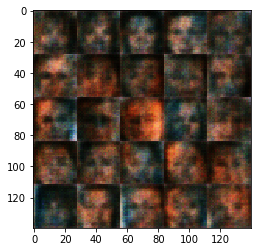

Epoch 1/1... Discriminator Loss: 1.8249... Generator Loss: 0.5423
Epoch 1/1... Discriminator Loss: 1.3377... Generator Loss: 0.8280
Epoch 1/1... Discriminator Loss: 1.3613... Generator Loss: 1.3612
Epoch 1/1... Discriminator Loss: 1.2992... Generator Loss: 1.1473
Epoch 1/1... Discriminator Loss: 1.3103... Generator Loss: 0.8280
Epoch 1/1... Discriminator Loss: 1.3827... Generator Loss: 0.9107
Epoch 1/1... Discriminator Loss: 1.4035... Generator Loss: 0.6465
Epoch 1/1... Discriminator Loss: 1.2819... Generator Loss: 0.9828
Epoch 1/1... Discriminator Loss: 1.3204... Generator Loss: 0.8445
Epoch 1/1... Discriminator Loss: 1.6269... Generator Loss: 0.4715


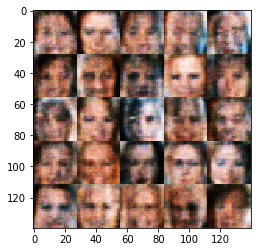

Epoch 1/1... Discriminator Loss: 1.2971... Generator Loss: 0.8937
Epoch 1/1... Discriminator Loss: 1.3167... Generator Loss: 0.9588
Epoch 1/1... Discriminator Loss: 1.1963... Generator Loss: 0.9816
Epoch 1/1... Discriminator Loss: 1.2462... Generator Loss: 0.8185
Epoch 1/1... Discriminator Loss: 1.1470... Generator Loss: 0.8803
Epoch 1/1... Discriminator Loss: 1.2184... Generator Loss: 1.4452
Epoch 1/1... Discriminator Loss: 1.4659... Generator Loss: 1.0934
Epoch 1/1... Discriminator Loss: 1.6309... Generator Loss: 1.3261
Epoch 1/1... Discriminator Loss: 1.5041... Generator Loss: 0.5677
Epoch 1/1... Discriminator Loss: 1.2557... Generator Loss: 0.9416


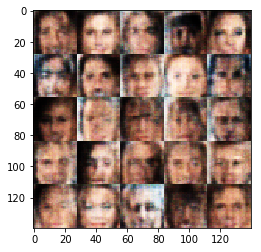

Epoch 1/1... Discriminator Loss: 1.5309... Generator Loss: 0.5331
Epoch 1/1... Discriminator Loss: 1.4563... Generator Loss: 0.6569
Epoch 1/1... Discriminator Loss: 1.5862... Generator Loss: 1.6819
Epoch 1/1... Discriminator Loss: 1.2117... Generator Loss: 1.0010
Epoch 1/1... Discriminator Loss: 1.8867... Generator Loss: 0.4768
Epoch 1/1... Discriminator Loss: 1.5433... Generator Loss: 0.5269
Epoch 1/1... Discriminator Loss: 1.3154... Generator Loss: 1.1531
Epoch 1/1... Discriminator Loss: 1.5163... Generator Loss: 0.4803
Epoch 1/1... Discriminator Loss: 1.3687... Generator Loss: 0.7896
Epoch 1/1... Discriminator Loss: 1.4835... Generator Loss: 0.5257


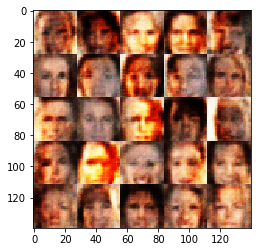

Epoch 1/1... Discriminator Loss: 1.1367... Generator Loss: 1.1295
Epoch 1/1... Discriminator Loss: 1.5341... Generator Loss: 0.5091
Epoch 1/1... Discriminator Loss: 1.6015... Generator Loss: 0.5647
Epoch 1/1... Discriminator Loss: 1.2786... Generator Loss: 0.9913
Epoch 1/1... Discriminator Loss: 1.2833... Generator Loss: 1.6104
Epoch 1/1... Discriminator Loss: 1.4661... Generator Loss: 0.5250
Epoch 1/1... Discriminator Loss: 1.3188... Generator Loss: 0.7730
Epoch 1/1... Discriminator Loss: 1.4191... Generator Loss: 0.6822
Epoch 1/1... Discriminator Loss: 1.5624... Generator Loss: 0.6360
Epoch 1/1... Discriminator Loss: 1.2925... Generator Loss: 0.9965


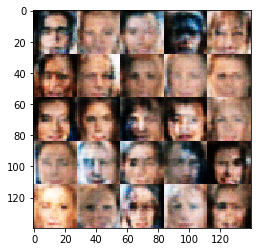

Epoch 1/1... Discriminator Loss: 1.2571... Generator Loss: 0.9027
Epoch 1/1... Discriminator Loss: 1.3211... Generator Loss: 0.9290
Epoch 1/1... Discriminator Loss: 1.3397... Generator Loss: 0.9758
Epoch 1/1... Discriminator Loss: 1.2764... Generator Loss: 1.3509
Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 0.6071
Epoch 1/1... Discriminator Loss: 1.4764... Generator Loss: 0.6881
Epoch 1/1... Discriminator Loss: 1.3617... Generator Loss: 1.6138
Epoch 1/1... Discriminator Loss: 1.3456... Generator Loss: 0.7924
Epoch 1/1... Discriminator Loss: 1.4947... Generator Loss: 0.9275
Epoch 1/1... Discriminator Loss: 1.3934... Generator Loss: 1.1343


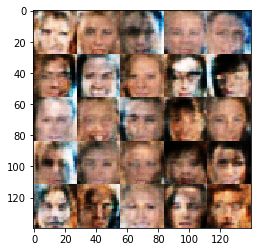

Epoch 1/1... Discriminator Loss: 1.2586... Generator Loss: 1.2307
Epoch 1/1... Discriminator Loss: 1.3531... Generator Loss: 0.8444
Epoch 1/1... Discriminator Loss: 1.2527... Generator Loss: 1.0750
Epoch 1/1... Discriminator Loss: 1.4051... Generator Loss: 0.7368
Epoch 1/1... Discriminator Loss: 1.3545... Generator Loss: 0.6305
Epoch 1/1... Discriminator Loss: 1.3172... Generator Loss: 1.1312
Epoch 1/1... Discriminator Loss: 1.3445... Generator Loss: 0.7453
Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 1.1039
Epoch 1/1... Discriminator Loss: 1.3341... Generator Loss: 1.2735
Epoch 1/1... Discriminator Loss: 1.2884... Generator Loss: 0.9065


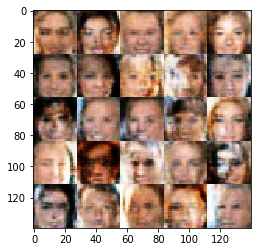

Epoch 1/1... Discriminator Loss: 1.4911... Generator Loss: 0.5160
Epoch 1/1... Discriminator Loss: 1.3788... Generator Loss: 0.8833
Epoch 1/1... Discriminator Loss: 1.5365... Generator Loss: 0.5809
Epoch 1/1... Discriminator Loss: 1.2577... Generator Loss: 0.9872
Epoch 1/1... Discriminator Loss: 1.3724... Generator Loss: 0.7534
Epoch 1/1... Discriminator Loss: 1.3284... Generator Loss: 0.8722
Epoch 1/1... Discriminator Loss: 1.3800... Generator Loss: 0.9843
Epoch 1/1... Discriminator Loss: 1.3194... Generator Loss: 0.8788
Epoch 1/1... Discriminator Loss: 1.3648... Generator Loss: 0.8215
Epoch 1/1... Discriminator Loss: 1.3197... Generator Loss: 0.9005


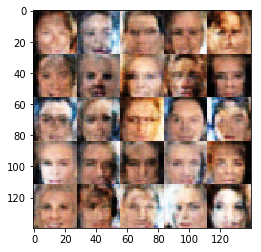

Epoch 1/1... Discriminator Loss: 1.3686... Generator Loss: 0.8952
Epoch 1/1... Discriminator Loss: 1.2962... Generator Loss: 0.8894
Epoch 1/1... Discriminator Loss: 1.2516... Generator Loss: 1.0065
Epoch 1/1... Discriminator Loss: 1.3213... Generator Loss: 0.9194
Epoch 1/1... Discriminator Loss: 1.4063... Generator Loss: 0.9585
Epoch 1/1... Discriminator Loss: 1.4388... Generator Loss: 0.8675
Epoch 1/1... Discriminator Loss: 1.3523... Generator Loss: 0.9935
Epoch 1/1... Discriminator Loss: 1.3143... Generator Loss: 0.9552
Epoch 1/1... Discriminator Loss: 1.3272... Generator Loss: 1.0081
Epoch 1/1... Discriminator Loss: 1.3211... Generator Loss: 0.9071


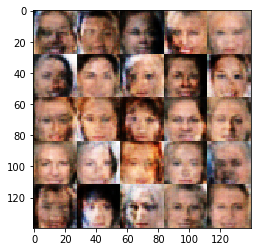

Epoch 1/1... Discriminator Loss: 1.3682... Generator Loss: 0.8205
Epoch 1/1... Discriminator Loss: 1.4944... Generator Loss: 1.0355
Epoch 1/1... Discriminator Loss: 1.4213... Generator Loss: 0.6102
Epoch 1/1... Discriminator Loss: 1.3703... Generator Loss: 0.7796
Epoch 1/1... Discriminator Loss: 1.3379... Generator Loss: 0.8550
Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.9108
Epoch 1/1... Discriminator Loss: 1.4497... Generator Loss: 0.7431
Epoch 1/1... Discriminator Loss: 1.4230... Generator Loss: 0.7640
Epoch 1/1... Discriminator Loss: 1.2758... Generator Loss: 0.9253
Epoch 1/1... Discriminator Loss: 1.3741... Generator Loss: 0.7854


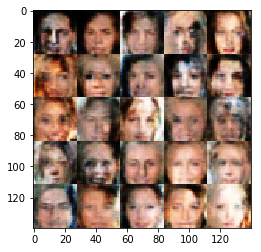

Epoch 1/1... Discriminator Loss: 1.3775... Generator Loss: 0.7760
Epoch 1/1... Discriminator Loss: 1.3990... Generator Loss: 0.8405
Epoch 1/1... Discriminator Loss: 1.4070... Generator Loss: 0.6008
Epoch 1/1... Discriminator Loss: 1.3621... Generator Loss: 0.8667
Epoch 1/1... Discriminator Loss: 1.3623... Generator Loss: 0.6426
Epoch 1/1... Discriminator Loss: 1.3796... Generator Loss: 0.7683
Epoch 1/1... Discriminator Loss: 1.2663... Generator Loss: 0.9378
Epoch 1/1... Discriminator Loss: 1.2504... Generator Loss: 0.7840
Epoch 1/1... Discriminator Loss: 1.2816... Generator Loss: 0.8816
Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.8090


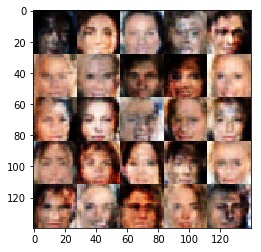

Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.8877
Epoch 1/1... Discriminator Loss: 1.2874... Generator Loss: 0.7664
Epoch 1/1... Discriminator Loss: 1.3244... Generator Loss: 0.9400
Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.9563
Epoch 1/1... Discriminator Loss: 1.3328... Generator Loss: 0.6708
Epoch 1/1... Discriminator Loss: 1.3049... Generator Loss: 0.8870
Epoch 1/1... Discriminator Loss: 1.3320... Generator Loss: 0.7225
Epoch 1/1... Discriminator Loss: 1.3281... Generator Loss: 0.8144
Epoch 1/1... Discriminator Loss: 1.3153... Generator Loss: 0.8339
Epoch 1/1... Discriminator Loss: 1.3613... Generator Loss: 0.8494


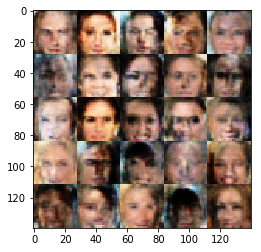

Epoch 1/1... Discriminator Loss: 1.2604... Generator Loss: 0.9575
Epoch 1/1... Discriminator Loss: 1.4289... Generator Loss: 0.6677
Epoch 1/1... Discriminator Loss: 1.4963... Generator Loss: 0.5349
Epoch 1/1... Discriminator Loss: 1.2911... Generator Loss: 0.9891
Epoch 1/1... Discriminator Loss: 1.3253... Generator Loss: 0.7913
Epoch 1/1... Discriminator Loss: 1.2667... Generator Loss: 0.7343
Epoch 1/1... Discriminator Loss: 1.2803... Generator Loss: 0.9843
Epoch 1/1... Discriminator Loss: 1.3883... Generator Loss: 0.9015
Epoch 1/1... Discriminator Loss: 1.2055... Generator Loss: 1.0620
Epoch 1/1... Discriminator Loss: 1.2956... Generator Loss: 0.7998


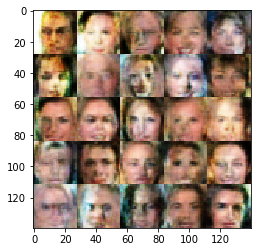

Epoch 1/1... Discriminator Loss: 1.3529... Generator Loss: 0.8587
Epoch 1/1... Discriminator Loss: 1.3807... Generator Loss: 1.1568
Epoch 1/1... Discriminator Loss: 1.3099... Generator Loss: 0.9766
Epoch 1/1... Discriminator Loss: 1.3561... Generator Loss: 1.0177
Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.6939
Epoch 1/1... Discriminator Loss: 1.3902... Generator Loss: 0.9297
Epoch 1/1... Discriminator Loss: 1.3449... Generator Loss: 0.8091
Epoch 1/1... Discriminator Loss: 1.3777... Generator Loss: 0.8466
Epoch 1/1... Discriminator Loss: 1.3406... Generator Loss: 0.9923
Epoch 1/1... Discriminator Loss: 1.3525... Generator Loss: 1.1145


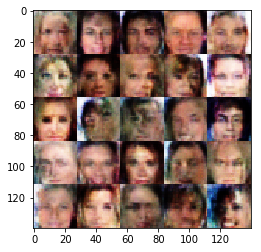

Epoch 1/1... Discriminator Loss: 1.3487... Generator Loss: 0.7803
Epoch 1/1... Discriminator Loss: 1.3731... Generator Loss: 0.8171
Epoch 1/1... Discriminator Loss: 1.3333... Generator Loss: 0.8608
Epoch 1/1... Discriminator Loss: 1.3201... Generator Loss: 0.7136
Epoch 1/1... Discriminator Loss: 1.3831... Generator Loss: 0.7450
Epoch 1/1... Discriminator Loss: 1.3952... Generator Loss: 1.0796
Epoch 1/1... Discriminator Loss: 1.3170... Generator Loss: 1.1514
Epoch 1/1... Discriminator Loss: 1.2912... Generator Loss: 0.8766
Epoch 1/1... Discriminator Loss: 1.2906... Generator Loss: 0.8948
Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.7421


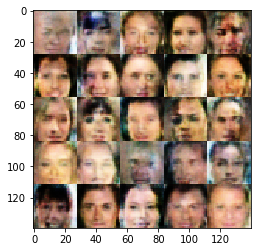

Epoch 1/1... Discriminator Loss: 1.4050... Generator Loss: 0.6816
Epoch 1/1... Discriminator Loss: 1.4056... Generator Loss: 0.8264
Epoch 1/1... Discriminator Loss: 1.3566... Generator Loss: 0.9833
Epoch 1/1... Discriminator Loss: 1.3688... Generator Loss: 0.7129
Epoch 1/1... Discriminator Loss: 1.2609... Generator Loss: 0.9038
Epoch 1/1... Discriminator Loss: 1.3341... Generator Loss: 0.8199
Epoch 1/1... Discriminator Loss: 1.3791... Generator Loss: 0.6854
Epoch 1/1... Discriminator Loss: 1.3028... Generator Loss: 0.9034
Epoch 1/1... Discriminator Loss: 1.3342... Generator Loss: 0.8205
Epoch 1/1... Discriminator Loss: 1.3743... Generator Loss: 0.9587


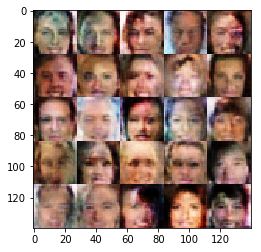

Epoch 1/1... Discriminator Loss: 1.4202... Generator Loss: 0.8615
Epoch 1/1... Discriminator Loss: 1.3398... Generator Loss: 0.7846
Epoch 1/1... Discriminator Loss: 1.3104... Generator Loss: 0.7911
Epoch 1/1... Discriminator Loss: 1.3542... Generator Loss: 0.7534
Epoch 1/1... Discriminator Loss: 1.3855... Generator Loss: 0.7915
Epoch 1/1... Discriminator Loss: 1.2525... Generator Loss: 0.8116
Epoch 1/1... Discriminator Loss: 1.4010... Generator Loss: 0.6733
Epoch 1/1... Discriminator Loss: 1.3096... Generator Loss: 0.8852
Epoch 1/1... Discriminator Loss: 1.3995... Generator Loss: 0.6999
Epoch 1/1... Discriminator Loss: 1.2515... Generator Loss: 0.8117


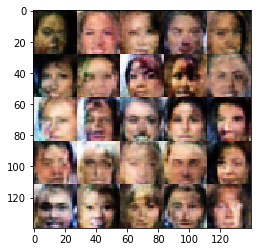

Epoch 1/1... Discriminator Loss: 1.3612... Generator Loss: 0.7607
Epoch 1/1... Discriminator Loss: 1.3430... Generator Loss: 0.7965
Epoch 1/1... Discriminator Loss: 1.3837... Generator Loss: 0.9802
Epoch 1/1... Discriminator Loss: 1.3652... Generator Loss: 0.6284
Epoch 1/1... Discriminator Loss: 1.3645... Generator Loss: 0.8037
Epoch 1/1... Discriminator Loss: 1.3761... Generator Loss: 0.8064
Epoch 1/1... Discriminator Loss: 1.3720... Generator Loss: 0.9530
Epoch 1/1... Discriminator Loss: 1.3415... Generator Loss: 0.6700
Epoch 1/1... Discriminator Loss: 1.3345... Generator Loss: 0.9175
Epoch 1/1... Discriminator Loss: 1.3696... Generator Loss: 0.7913


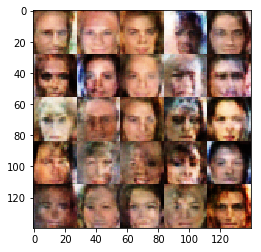

Epoch 1/1... Discriminator Loss: 1.2562... Generator Loss: 0.9654
Epoch 1/1... Discriminator Loss: 1.3089... Generator Loss: 1.0540
Epoch 1/1... Discriminator Loss: 1.3542... Generator Loss: 0.6973
Epoch 1/1... Discriminator Loss: 1.2968... Generator Loss: 0.8824
Epoch 1/1... Discriminator Loss: 1.6043... Generator Loss: 0.5458
Epoch 1/1... Discriminator Loss: 1.3117... Generator Loss: 0.9309
Epoch 1/1... Discriminator Loss: 1.3655... Generator Loss: 0.7959
Epoch 1/1... Discriminator Loss: 1.3645... Generator Loss: 0.7829
Epoch 1/1... Discriminator Loss: 1.4141... Generator Loss: 0.8229
Epoch 1/1... Discriminator Loss: 1.3812... Generator Loss: 0.7375


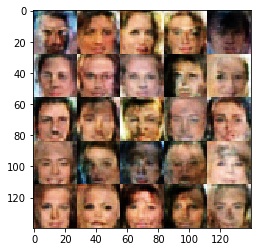

Epoch 1/1... Discriminator Loss: 1.3248... Generator Loss: 0.7214
Epoch 1/1... Discriminator Loss: 1.3431... Generator Loss: 0.7344
Epoch 1/1... Discriminator Loss: 1.4389... Generator Loss: 1.1343
Epoch 1/1... Discriminator Loss: 1.3565... Generator Loss: 0.8260
Epoch 1/1... Discriminator Loss: 1.3479... Generator Loss: 0.7164
Epoch 1/1... Discriminator Loss: 1.4057... Generator Loss: 0.6267
Epoch 1/1... Discriminator Loss: 1.3287... Generator Loss: 0.8066
Epoch 1/1... Discriminator Loss: 1.3479... Generator Loss: 1.0509
Epoch 1/1... Discriminator Loss: 1.3198... Generator Loss: 0.8297
Epoch 1/1... Discriminator Loss: 1.2629... Generator Loss: 0.9600


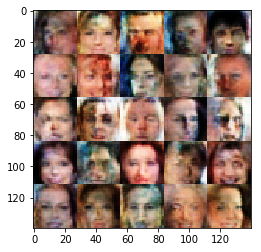

Epoch 1/1... Discriminator Loss: 1.2942... Generator Loss: 1.1257
Epoch 1/1... Discriminator Loss: 1.2681... Generator Loss: 0.9526
Epoch 1/1... Discriminator Loss: 1.3100... Generator Loss: 0.9071
Epoch 1/1... Discriminator Loss: 1.3276... Generator Loss: 0.7290
Epoch 1/1... Discriminator Loss: 1.3741... Generator Loss: 1.1454
Epoch 1/1... Discriminator Loss: 1.3173... Generator Loss: 0.7257
Epoch 1/1... Discriminator Loss: 1.3058... Generator Loss: 0.8589
Epoch 1/1... Discriminator Loss: 1.3603... Generator Loss: 0.8814
Epoch 1/1... Discriminator Loss: 1.3929... Generator Loss: 0.8884
Epoch 1/1... Discriminator Loss: 1.2634... Generator Loss: 0.8773


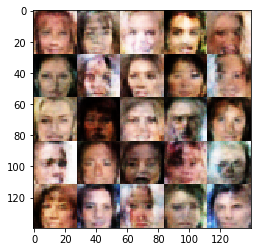

Epoch 1/1... Discriminator Loss: 1.3481... Generator Loss: 0.8152
Epoch 1/1... Discriminator Loss: 1.3371... Generator Loss: 0.8341
Epoch 1/1... Discriminator Loss: 1.3861... Generator Loss: 0.8082
Epoch 1/1... Discriminator Loss: 1.3812... Generator Loss: 0.9241
Epoch 1/1... Discriminator Loss: 1.3562... Generator Loss: 0.9390
Epoch 1/1... Discriminator Loss: 1.4145... Generator Loss: 0.8324
Epoch 1/1... Discriminator Loss: 1.3690... Generator Loss: 1.0909
Epoch 1/1... Discriminator Loss: 1.4309... Generator Loss: 0.5786
Epoch 1/1... Discriminator Loss: 1.3609... Generator Loss: 0.7189
Epoch 1/1... Discriminator Loss: 1.3293... Generator Loss: 0.7469


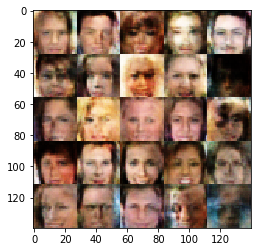

Epoch 1/1... Discriminator Loss: 1.3851... Generator Loss: 0.8605
Epoch 1/1... Discriminator Loss: 1.3714... Generator Loss: 0.6785
Epoch 1/1... Discriminator Loss: 1.3029... Generator Loss: 0.8591
Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 0.9162
Epoch 1/1... Discriminator Loss: 1.3169... Generator Loss: 0.8485
Epoch 1/1... Discriminator Loss: 1.3329... Generator Loss: 0.9621
Epoch 1/1... Discriminator Loss: 1.2983... Generator Loss: 0.9294
Epoch 1/1... Discriminator Loss: 1.3472... Generator Loss: 0.8354
Epoch 1/1... Discriminator Loss: 1.3481... Generator Loss: 0.8314
Epoch 1/1... Discriminator Loss: 1.4706... Generator Loss: 0.5809


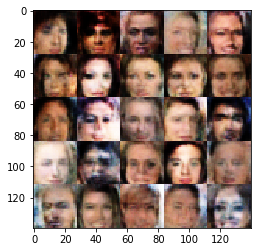

Epoch 1/1... Discriminator Loss: 1.3130... Generator Loss: 0.6953
Epoch 1/1... Discriminator Loss: 1.3361... Generator Loss: 0.7273
Epoch 1/1... Discriminator Loss: 1.3547... Generator Loss: 0.9708
Epoch 1/1... Discriminator Loss: 1.3217... Generator Loss: 0.7038
Epoch 1/1... Discriminator Loss: 1.3855... Generator Loss: 1.0100
Epoch 1/1... Discriminator Loss: 1.2992... Generator Loss: 0.6912
Epoch 1/1... Discriminator Loss: 1.3030... Generator Loss: 0.9524
Epoch 1/1... Discriminator Loss: 1.3218... Generator Loss: 0.8694
Epoch 1/1... Discriminator Loss: 1.3795... Generator Loss: 0.7234
Epoch 1/1... Discriminator Loss: 1.3312... Generator Loss: 0.7568


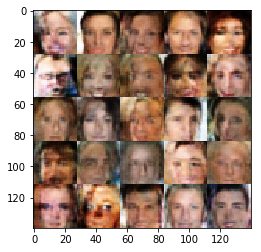

Epoch 1/1... Discriminator Loss: 1.5026... Generator Loss: 1.2378
Epoch 1/1... Discriminator Loss: 1.3768... Generator Loss: 0.7606
Epoch 1/1... Discriminator Loss: 1.2750... Generator Loss: 0.9074
Epoch 1/1... Discriminator Loss: 1.3585... Generator Loss: 0.7559
Epoch 1/1... Discriminator Loss: 1.3904... Generator Loss: 0.8552
Epoch 1/1... Discriminator Loss: 1.4041... Generator Loss: 0.8806
Epoch 1/1... Discriminator Loss: 1.3197... Generator Loss: 0.7016
Epoch 1/1... Discriminator Loss: 1.3309... Generator Loss: 0.7462
Epoch 1/1... Discriminator Loss: 1.2580... Generator Loss: 0.7052
Epoch 1/1... Discriminator Loss: 1.3277... Generator Loss: 0.8639


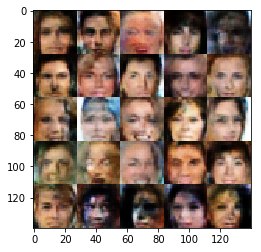

Epoch 1/1... Discriminator Loss: 1.3734... Generator Loss: 0.7660
Epoch 1/1... Discriminator Loss: 1.3793... Generator Loss: 0.9211
Epoch 1/1... Discriminator Loss: 1.3734... Generator Loss: 0.8531
Epoch 1/1... Discriminator Loss: 1.3336... Generator Loss: 0.9785
Epoch 1/1... Discriminator Loss: 1.4172... Generator Loss: 0.7322
Epoch 1/1... Discriminator Loss: 1.3254... Generator Loss: 0.8299
Epoch 1/1... Discriminator Loss: 1.3245... Generator Loss: 0.6905
Epoch 1/1... Discriminator Loss: 1.3695... Generator Loss: 0.6905
Epoch 1/1... Discriminator Loss: 1.4417... Generator Loss: 0.5932
Epoch 1/1... Discriminator Loss: 1.3528... Generator Loss: 0.6200


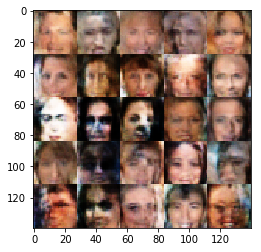

Epoch 1/1... Discriminator Loss: 1.4325... Generator Loss: 0.7121
Epoch 1/1... Discriminator Loss: 1.2519... Generator Loss: 0.8421
Epoch 1/1... Discriminator Loss: 1.2967... Generator Loss: 0.8949
Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 0.8134
Epoch 1/1... Discriminator Loss: 1.3790... Generator Loss: 0.9223
Epoch 1/1... Discriminator Loss: 1.5317... Generator Loss: 0.5372
Epoch 1/1... Discriminator Loss: 1.3328... Generator Loss: 0.8977
Epoch 1/1... Discriminator Loss: 1.3314... Generator Loss: 0.7950
Epoch 1/1... Discriminator Loss: 1.3270... Generator Loss: 0.8082
Epoch 1/1... Discriminator Loss: 1.3086... Generator Loss: 0.8637


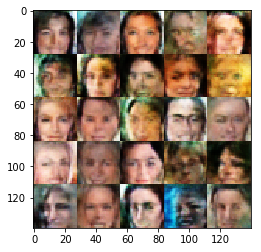

Epoch 1/1... Discriminator Loss: 1.3152... Generator Loss: 0.8873
Epoch 1/1... Discriminator Loss: 1.3274... Generator Loss: 0.8819
Epoch 1/1... Discriminator Loss: 1.3286... Generator Loss: 0.7450
Epoch 1/1... Discriminator Loss: 1.3538... Generator Loss: 0.9787
Epoch 1/1... Discriminator Loss: 1.4706... Generator Loss: 0.6418
Epoch 1/1... Discriminator Loss: 1.3681... Generator Loss: 0.9992
Epoch 1/1... Discriminator Loss: 1.3890... Generator Loss: 0.7887
Epoch 1/1... Discriminator Loss: 1.4493... Generator Loss: 0.5903
Epoch 1/1... Discriminator Loss: 1.2751... Generator Loss: 0.9517
Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 1.1317


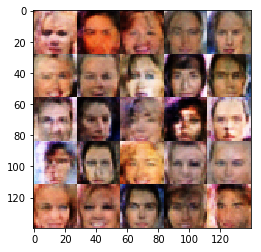

Epoch 1/1... Discriminator Loss: 1.4703... Generator Loss: 0.5717
Epoch 1/1... Discriminator Loss: 1.4238... Generator Loss: 0.7359
Epoch 1/1... Discriminator Loss: 1.3188... Generator Loss: 0.8175
Epoch 1/1... Discriminator Loss: 1.3361... Generator Loss: 0.9811
Epoch 1/1... Discriminator Loss: 1.2676... Generator Loss: 0.8766
Epoch 1/1... Discriminator Loss: 1.4179... Generator Loss: 0.6070
Epoch 1/1... Discriminator Loss: 1.3459... Generator Loss: 0.7371
Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.7703
Epoch 1/1... Discriminator Loss: 1.5308... Generator Loss: 0.4890
Epoch 1/1... Discriminator Loss: 1.3647... Generator Loss: 0.9110


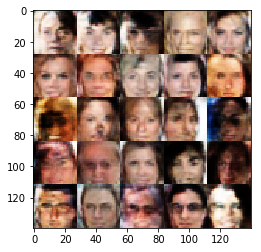

Epoch 1/1... Discriminator Loss: 1.3373... Generator Loss: 0.9676
Epoch 1/1... Discriminator Loss: 1.3541... Generator Loss: 0.8177
Epoch 1/1... Discriminator Loss: 1.3289... Generator Loss: 0.9993
Epoch 1/1... Discriminator Loss: 1.4011... Generator Loss: 0.7575
Epoch 1/1... Discriminator Loss: 1.2972... Generator Loss: 0.7462
Epoch 1/1... Discriminator Loss: 1.3612... Generator Loss: 1.0011
Epoch 1/1... Discriminator Loss: 1.3517... Generator Loss: 1.1599
Epoch 1/1... Discriminator Loss: 1.4084... Generator Loss: 1.0343
Epoch 1/1... Discriminator Loss: 1.2731... Generator Loss: 0.8450
Epoch 1/1... Discriminator Loss: 1.3126... Generator Loss: 0.8765


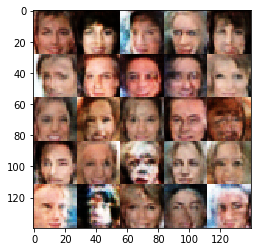

Epoch 1/1... Discriminator Loss: 1.3327... Generator Loss: 0.7023
Epoch 1/1... Discriminator Loss: 1.3958... Generator Loss: 0.6735
Epoch 1/1... Discriminator Loss: 1.3124... Generator Loss: 0.8876
Epoch 1/1... Discriminator Loss: 1.3269... Generator Loss: 0.7335
Epoch 1/1... Discriminator Loss: 1.3691... Generator Loss: 0.7574
Epoch 1/1... Discriminator Loss: 1.3410... Generator Loss: 0.7615


In [73]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.